# Preparing ARIA standard GUNW products layers for time-series analysis using ariaTSsetup.py

**Author**: Simran Sangha, David Bekaert - Jet Propulsion Laboratory

This notebook provides an overview of the functionality included in the **ariaTSsetup.py** program. Specifically, we give examples on how to extract data and meta-data layers from ARIA Geocoded UNWrapped interferogram (GUNW) products over a user defined area of interest and prepare the data into a stack for time-series ingestion.

In this notebook, we will demonstrate how to:
- Extract data layers (unwrapped phase, coherence) and imaging geometry layers (azimuth angle, incidence angle, look angle) necessary for building time-series
- Prepare the extracted data into a stack for time-series ingestion

    
<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. The overview sections do not need to be run in order. In the application section the ariaTSsetup commandline call at the top must be run first, but the rest of the section does not need to be run in order.
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
    
- GDAL uses "HDF5" driver instead of "netCDF/Network Common Data Format" on GUNW products. Verify GDAL version >= 3.
- ARIA-tools needs to be installed to run this notebook
</div>


<div class="alert alert-info">
    <b>Terminology:</b>
    
- *Acquisition*: An image acquired by the satellite for a given date and time.
- *Interferogram*: An unwrapped image containing the surface displacement accumulated between two acquisitions.
- *Frame*: Outline of a product ground footprint.
- *Along-track*: The direction along satellite flight path. 
    </div>
    

## Prep A. Initial setup of the notebook

Below we set up the directory structure for this notebook exercise. In addition, we load the required modules into our python environment using the **`import`** command. We also explicitly enable exceptions for GDAL as this allows us to capture GDAL errors.

In [3]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = False

# ------------------------------------------------------------------------------------------- #
# no changed below needed:

import os, copy
import shutil
import subprocess
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter, StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
    

## Defining the home and data directories at the processing location
work_dir = os.path.abspath(os.getcwd())
tutorial_home_dir = os.path.abspath(os.getcwd())
print("Work directory: ", work_dir)
print("Tutorial directory: ", tutorial_home_dir)

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

# Verifying if ARIA-tools is installed correctly
try:
    import ARIAtools.util.shp as shputil
except:
    raise Exception('ARIA-tools is missing from your PYTHONPATH')
        
os.chdir(work_dir)

if Use_Staged_Data:
    # Check if a stage file from S3 already exist, if not try and download it
    f = 'ariaTSsetup.zip'
    if not os.path.isfile(f):
        print('\nAttempting to download staged data ... ')
        try:
            cmd = f'aws s3 cp --region us-east-1 --no-sign-request s3://asf-jupyter-data/aria-data/{f} {f}'
            subprocess.run(cmd, shell=True, check=True)
                
        except:
            cmd = f'wget --no-check-certificate --no-proxy http://asf-jupyter-data-west.s3.amazonaws.com/aria-data/{f} {f} -q --show-progress'
            subprocess.run(cmd, stdout=None, stderr=subprocess.PIPE, shell=True)


    # verify if download was succesfull
    if os.path.isfile(f):
        if os.path.exists('products'):

            shutil.rmtree('products')
        !unzip {f}
        print('S3 pre-staged data retrieval was successful')
    else:
        print("Download outside openSarLabs is not supported.\nAs alternative please start from ARIA-tools with the commandline calls provided at the top of this notebook")          
else:
    print("Will not be using S3 pre-staged data")


Work directory:  /Users/rzinke/Documents/ARIAdev/ARIA-tools-docs/JupyterDocs/ariaTSsetup
Tutorial directory:  /Users/rzinke/Documents/ARIAdev/ARIA-tools-docs/JupyterDocs/ariaTSsetup
Will not be using S3 pre-staged data


DEMs are accessed/downloaded through OpenTopography. Downloading them requires an OpenTopography api key.

Follow instructions listed here to generate and access API key through OpenTopography:
https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets

Once the api key is acquired, your local **`.topoapi`** may be populated by executing the next cell

In [4]:
# create .topoapi if it does not exist    
if not os.path.exists(os.path.expanduser('~/.topoapi')):
    print('API key location: My Account > myOpenTopo Authorizations and API Key > Request API key')
    opentopography_api_key = input('Please type your OpenTopo API key:')
    opentopography_api_key = str(opentopography_api_key)
    os.system('echo "{api_key}" > ~/.topoapi; chmod 600 ~/.topoapi'.format(api_key = str(opentopography_api_key)))

Below we define a plotting function that will be used throughout the notebook for plotting GDAL compatible datasets on a map.

In [5]:
def plot_layer(path_layer, lay_type=None, cmap=None, n_bands=None, **kwargs):
    """  'path_layer' is a string to the GDAL compatible dataset to be plotted """   
    if not lay_type: 
        lay_type = os.path.dirname(path_layer)
    title = [os.path.basename(lay_type)]
    
    ## get the lon lat bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]
    
    ## loading the data
    if not n_bands:
        n_bands  = ds.RasterCount
    lst_arrs = []
    
    for band in range(n_bands):
        raster = ds.GetRasterBand(band+1)
        arr    = raster.ReadAsArray()
        try:
            NoData = raster.GetNoDataValue()
            arr = np.ma.masked_where((arr>1e20) |(arr==NoData),arr )
        except:
            print('Could not find a no-data value...')
            arr = np.ma.masked_where(arr>1e20,arr)
        
        lst_arrs.append(arr)

    ds = None
    if n_bands < 4:
        nrows = 1; ncols = n_bands
    else:
        raise Exception('Number of bands currently unsupported')
        
    
    ## initializing a figure
    fig, axes = plt.subplots(figsize=(12,9), ncols=ncols, nrows=nrows, sharex='col', sharey='row')
    axes = axes if isinstance(axes, np.ndarray) else np.array(axes)
    axe  = axes.ravel() 
    cmap = copy.copy(plt.cm.Greys_r)
    cmap.set_under('black')
    vmin = None
    vmax = None
    
    ## definging the plotting options for different layer types
    # Amplitude:
    if lay_type.endswith('amplitude'): 
        # will fix the maximum amplitude bound
        vmax = 2000 
   
    # Coherence:
    elif lay_type.endswith('coherence'): 
        # has fixed range between 0-1
        vmin, vmax = 0, 1

    # water
    elif lay_type.startswith('water'):
        # no bounds needed will be a 0/1 mask
        vmin=0
        vmax=1
        cmap='Greys'

    # deformation or unwrapped phase
    elif lay_type.startswith('defo'): 
        cmap = plt.cm.coolwarm
   
    elif lay_type.startswith('terr') or lay_type.startswith('topo'): 
        cmap = plt.cm.terrain
    
    elif lay_type == 'ENU':
        title = ['East', 'North', 'Up']
        fig.subplots_adjust(wspace=0.5)

    else:
        # change colormap to a warm type
        cmap = plt.cm.coolwarm
        
    # plotting the data    
    for i, ax in enumerate(axe):
        im   = ax.imshow(lst_arrs[i], cmap=cmap, vmin=vmin, vmax=vmax, extent=extent,interpolation='nearest')
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='5%', pad=0.25)
        if lay_type == 'ENU':
            fig.colorbar(im, cax=cax, format=FuncFormatter(lambda x, y: '{:.3f}'.format(x)))
        elif lay_type.startswith('water'):
            fig.colorbar(im, cax=cax, ticks=[vmin, vmax])
        else:
            fig.colorbar(im, cax=cax)

        ax.set_title(title[i], fontsize=15)
        ax.grid(False)

    axe[0].set_ylabel('latitude', labelpad=15, fontsize=15)
    axe[int(np.floor(n_bands/2))].set_xlabel('longitude', labelpad=15, fontsize=15)

## Prep B: Download the data

We will use San Francisco as the study area for this tutorial (see **Fig. 1**). Specifically, we will use Sentinel-1 interferograms generated on track 42, spanning the start of the Sentinel-1 mission phase in late 2014 up until the present day.

ARIA provides unwrapped interferograms as GUNW products. As the spatial extent of a product is roughly the size of a single Sentinel-1 SLC frame (250km x 250km), it is likely that a given interferogram over this study area is composed of multiple adjacent GUNW frames or products.

<img src="./support_docs/track_042.png" alt="track" width="600">

<blockquote><b>Fig. 1</b> Image of San Francisco study area centered along Track 42. Blue and white boxes denote footprint of a product and the bounding box of our study area. Faults from USGS Quaternary fault catalog are plotted in background. For interpretation of fault trace colors, refer to see <a href="https://earthquake.usgs.gov/hazards/qfaults/">USGS fault catalogue website </a>. </blockquote>

### ARIA GUNW products

The GUNW product is an InSAR surface displacement product derived from Sentinel-1 SAR data and packaged as netCDF4 files. GUNW products contain both data and meta-data layers such as the interferometric amplitude, filtered unwrapped phase, filtered coherence, connected components, perpendicular and parallel baselines, incidence, azimuth and look angles. A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the [ARIA website](https://aria.jpl.nasa.gov/node/97).

### Download options

GUNW products are hosted at the ASF DAAC and can be downloaded from the [ARIA-products page](https://aria-products.jpl.nasa.gov) and as beta products from the [ASF DAAC data search page](https://search.asf.alaska.edu/#/). If you know the GUNW filename of the product, you can also build a download link by appending the GUNW filename to **https://<i></i>grfn.asf.alaska.edu<i></i>/door/download/** . 

Alternatively, you can use the **`ariaDownload.py`** program provided within the ARIA-tools package to download data using a command-line interface. This program wraps around the ASF DAAC API and allows for search sub-setting of GUNW products based on track number, geometry (ascending or descending), as well as spatial and temporal bounding boxes criteria. For a full description of the **`ariaDownload.py`** program, see the [ariaDownload Tutorial](https://github.com/aria-tools/ARIA-tools-docs/blob/master/JupyterDocs/ariaDownload/ariaDownload_tutorial.ipynb).

<div class="alert alert-warning">
<b>Potential download failure:</b> 
GUNW products are hosted at the NASA ASF DAAC. Downloading them requires a NASA Earthdata URS user login and requires users to add “ARIA Product Search” to their URS approved applications

<b>Login Credentials:</b>
Save your user-name and password to a `.netrc` file in your `$HOME` directory, or pass the combination explicitly using `ariaDownload.py --user <user> --pass <pass>`.


To create a .netrc file, pass your earthdata credentials by running the cell below

<div class="alert alert-danger">
<b>Download</b>:     
    
- Can take up to 40 mins, so this is a good moment to take a coffee-break! - The ***jupyter notebook* does not allow for interactive entering of your user-name and password, use the *jupyter terminal* instead** with the same command for interactive use.
</div>

In [6]:
# create .netrc if it does not exist    
if not os.path.exists(os.path.expanduser('~/.netrc')):
    print('NEEDED To Download ARIA GUNWs: \n Link to create account : https://urs.earthdata.nasa.gov/')
    earthdata_user = input('Please type your Earthdata username:')
    earthdata_user = str(earthdata_user)
    earthdata_password = input('Please type your Earthdata password:')
    earthdata_password = str(earthdata_password)
    os.system('echo machine urs.earthdata.nasa.gov login "{usern}" password "{passwd}" > ~/.netrc; chmod 600 ~/.netrc'.format( \
              usern = earthdata_user, passwd = earthdata_password))

In [7]:
if not Use_Staged_Data:
    # limit to 88 products
    !ariaDownload.py --track 35 --bbox '37.25 38.1 -122.6 -121.75' --start 20190101 --end 20200101 --version '3_0_1'

/opt/miniconda3/envs/ARIA-tools/bin/ariaDownload.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
2024-07-24 16:20:27,068 - ariaDownload.py - INFO - Downloading 190 products...
2024-07-24 16:20:27,070 - ariaDownload.py - INFO - Download complete. Wrote -- 190 -- products to: /Users/rzinke/Documents/ARIAdev/ARIA-tools-docs/JupyterDocs/ariaTSsetup/products


We can now have a look at the downloaded products:

In [8]:
!ls products

S1-GUNW-A-R-035-tops-20190121_20190109-020645-00124W_00036N-PP-6403-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190121_20190109-020710-00124W_00037N-PP-a861-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190214_20190109-020644-00124W_00036N-PP-91ad-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190214_20190109-020709-00124W_00037N-PP-ebce-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190214_20190121-020644-00124W_00036N-PP-d6db-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190214_20190121-020709-00124W_00037N-PP-54a7-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190226_20190109-020644-00124W_00036N-PP-d836-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190226_20190109-020709-00124W_00037N-PP-605e-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190226_20190121-020644-00124W_00036N-PP-4bc9-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190226_20190121-020709-00124W_00037N-PP-5b2c-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190226_20190214-020644-00124W_00036N-PP-24c3-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190226_20190214-020709-00124W_00037N-PP-60f1-v3_0_1.nc
S1-GUNW-A-R-035-tops-20190310_20190121-020644-00124W_00036N-PP-a

The product filename has two fields, **XXYYYN/S-XXYYYN/S**, that are respectively associated with the western edge of south and north most corner of the geocoded interferogram (see [aria-website](https://aria.jpl.nasa.gov/products/standard-displacement-products.html) for a complete overview of the filename convention). The latitude bounds are specified as 5-digit number with 3 significant digits. The `duplicated_products` directory contains products that are the same except for the version. The default is to keep the newest versions and store any others in `duplicated_products`.

## Overview of the ariaTSsetup.py program
<a id='overview'></a>

The **`ariaTSsetup.py`** program allows for easy time-series preparation of relevant data and meta-data layers from ARIA standard GUNW products. The **`ariaTSsetup.py`** program is functionally very similar to the **`ariaExtract.py`** program, aside from the aforementioned note that the former prepares extracted data into a stack for time-series ingestion. The program will automatically determine which GUNW products need to be stitched or cropped in order to generate a seamless interferogram. By default, interferograms will be cropped to bounds determined by the common intersection and bounding box (if specified). Running **`ariaTSsetup.py`** with the **`-h`** option will show the parameter options. 

Let us explore these options:

In [9]:
!ariaTSsetup.py -h

/opt/miniconda3/envs/ARIA-tools/bin/ariaTSsetup.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
usage: ariaTSsetup.py [-h] -f IMGFILE [-w WORKDIR] [-gp GACOS_PRODUCTS]
                      [-l LAYERS] [-tm TROPO_MODELS] [-d DEMFILE]
                      [-p PROJECTION] [-b BBOX] [-m MASK] [-at AMP_THRESH]
                      [-nt NUM_THREADS] [-of OUTPUTFORMAT] [-croptounion]
                      [-ml MULTILOOKING] [-rr] [-mo MINIMUMOVERLAP]
                      [--version VERSION] [--nc_version NC_VERSION] [-verbose]
                      [--log-level LOG_LEVEL]

Prepare ARIA products for time series processing.

options:
  -h, --help            show this help message and exit
  -f IMGFILE, --file IMGFILE
                        ARIA file
  -w WORKDIR, --workdir WORKDIR
                        Specify directory to deposit all outputs. Default is


### 1. Product files to be used (-f option)

At minimum, users need to specify the GUNW files they want to extract information from. This is controlled using the **`-f`** option. Multiple products can be specified by providing them as a comma separated string (e.g., **`-f`**` 'products/S1-GUNW-D-R-042-tops-20150605_20150512-140722-39616N_37642N-PP-e396-v2_0_0.nc,products/S1-GUNW-D-R-042-tops-20150629_20150512-140723-39615N_37641N-PP-0e95-v2_0_0.nc'`), or using a wildcard (e.g., **`-f`**` 'products/S1*.nc'`).

### 2. Layers to be extracted (-l option)

By default the following are extracted: bounding boxes of the products, the "unwrappedPhase", "coherence", "incidenceAngle", "lookAngle", and "azimuthAngle" layers necessary for building time-series. Layer extraction is controlled using the **`-l`** option. Additional valid options are "amplitude", "bPerpendicular", and "bParallel". Multiple layers can be extracted at once by specifying them as a comma separated string (e.g., **`-l`**` 'azimuth,bParallel'`). You can use the `'all'` keyword to extract all possible layers at once (e.g., **`-l`**` all`).

### 3. DEM (-d and -p options)

By specifying the **`-d`**` Download` option, users can download the Copernicus GLO-90 DEM on the fly. The DEM will be cropped over the interferogram extent (ground swath). A DEM is required for extracting the meta-data layer fields (e.g., "bPerpendicular", "bParallel", "incidenceAngle","lookAngle", and "azimuthAngle"). Alternatively, users can also specify the location to a custom GDAL-compatible DEM and control its projection by specifying it with the **`-p`** option. All the meta-data layers are stored within the GUNW product as 3D data cubes (longitude, latitude, height). The full-resolution meta-data layers are generated by intersecting these 3D data-cube with the DEM.

### 4. Mask (-m option)

By specifying the **`-m`**` Download` option, users can download a waterbody mask compiled from the Global Self-consistent, Hierarchical, High-resolution Geography Database (GSHHG) on the fly. The mask will be cropped over the interferogram extent (ground swath). A mask is useful for masking out broader waterbodies (e.g. oceans and major lakes) from your output layers. Alternatively, users can also specify the location to a custom GDAL-compatible mask and control its projection by specifying it with the **`-p`** option.

### 5. Cropping and spatial sub setting (--bbox and -croptounion options)

The **`ariaTSsetup.py`** program will automatically handle cropping and stitching of GUNW products when needed. By default, the program will crop all interferograms to bounds determined by the common intersection (of all interferograms) and the user-defined bounding box (**`-bbox`** SNWE option). All layers are cropped and/or stitched using GDAL (see the methods section for details on the implemented approach for each layer).

### 6. Workdirectory (-w option)

The output of the **`ariaTSsetup.py`** program is saved within the working directory (**`-w`**), which by default is the current directory. Within the work directory the outputs are organized in separate subdirectories, where the sub-directory name corresponds to the layer being extracted. Within each subdirectory, the data and meta-data are saved with the interferogram pair dates "date1_date2" serving as the basename.

### 7.  Output format (-o option)

The **`ariaTSsetup.py`** program leverages GDAL for file reading and writing of outputs. The user can therefore specify any GDAL compatible format (e.g., ENVI, ISCE, GTiff; see GDAL for more information on supported formats) for saving the outputs from **`ariaTSsetup.py`**.  By default, "unwrappedPhase", "bPerpendicular", "bParallel", "incidenceAngle", "lookAngle", and "azimuthAngle" are stored as ENVI files, as these layers required  mathematical manipulation. Other layers including "coherence" and "amplitude" do not require this, and by default are stored as virtual files (.vrt) to conserve disk space.

Use **`ariaTSsetup.py`** to build a stack of products for time-series ingestion. We will use the GUNW products you have already downloaded into a *products* subfolder within in your specified *work directory* (**`-w`** option), which were collected on track *42* over the San Francisco area *'37.25 38.1 -122.6 -121.75'* (**`-bbox`** SNWE option) and spanning from late 2014 through to the present day.

## Application of ariaTSprep.py program 

### Set up time-series stack, download DEM and mask using ariaTSsetup.py

In [1]:
!ariaTSsetup.py -f 'products/*.nc' -b '37.25 38.1 -122.6 -121.75' -d Download --mask Download -nt 10 -l 'solidEarthTide,troposphereTotal,ionosphere' -tm HRRR

/opt/miniconda3/envs/ARIA-tools/bin/ariaTSsetup.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
2024-07-24 15:11:51,939 - ARIAtools.util.dem - WARNING - Cannot proceed with VRT format, using ENVI format instead
Reading tile imagery: 100%|███████████████████████| 1/1 [00:04<00:00,  4.20s/it]
2024-07-24 15:13:37,681 - ARIAtools.extractProduct - WARNING - Deleting ./incidenceAngle to avoid VRT header bug!
2024-07-24 15:13:37,687 - ARIAtools.extractProduct - WARNING - Deleting ./lookAngle to avoid VRT header bug!
2024-07-24 15:13:37,692 - ARIAtools.extractProduct - WARNING - Deleting ./azimuthAngle to avoid VRT header bug!
Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2024, May 22). GNU Parallel 20240522 

Extract and crop layers to the box defined for the San Francisco area *'37.25 38.1 -122.6 -121.75'* (**`-bbox`** SNWE option), download a DEM (**`-d Download`** option) which is needed to extract meta-data layers prerequisite for time-series analysis, and download a mask (**`-m Download`** option) to remove waterbodies.

The default data layers (unwrapped phase, coherence) and imaging geometry layers (azimuth angle, incidence angle, look angle) necessary for building time-series have been extracted. Layers are extracted to separate subdirectories named after the 'layer name' under the specified working directory (`-w`), e.g. 'unwrappedPhase'. Within the layer subdirectories, the data and meta-data are saved with a given interferometric date combination serving as the filename, e.g. 'unwrappedPhase/20150605_20150512'. Any existing layers will be overwritten.

### View downloaded mask

To download a waterbody mask compiled from GSHHG, we specified the **`-m Download`** option. By default, outputs are written to the local directory, which can be changed to another location by specifying the path with the **`-w`** option. The mask will be applied to all extracted layers.

The mask is cropped to the common interferometric grid, stored under local subdirectory *mask*, and given the filename *watermask.msk* (i.e. nested as *mask/watermask.msk*). Note that for consistency, if a user specifies a path to a custom mask, the cropped version is still stored under the local subdirectory *mask* and shares the same filename as the input.

Execute the next cell to visualize the mask. Broader waterbodies (e.g. oceans and major lakes) are delineated in the mask.

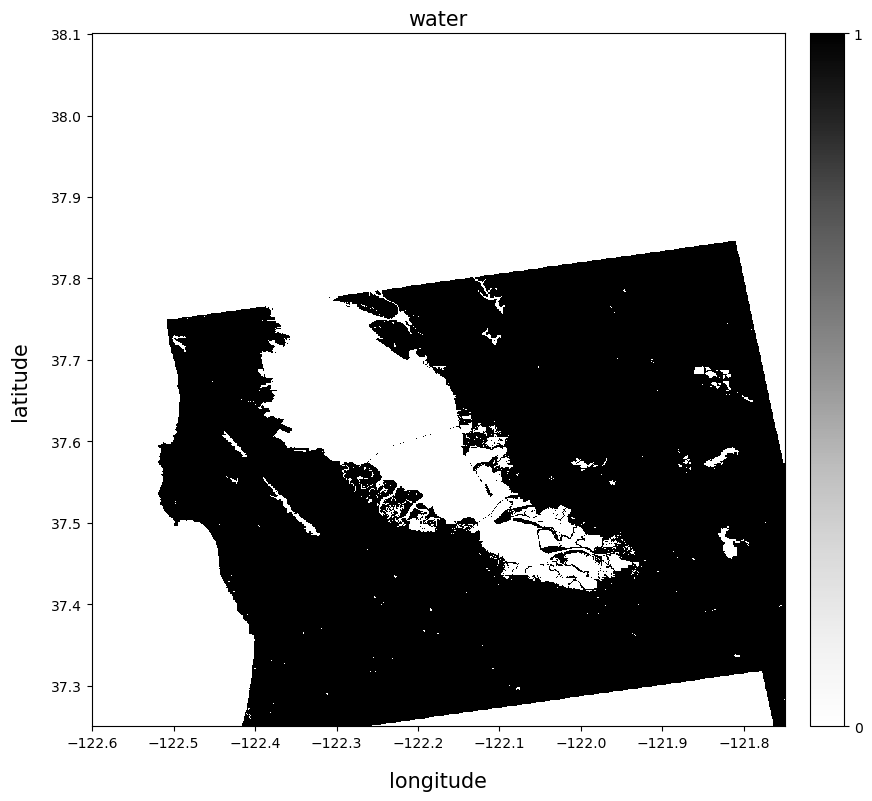

In [10]:
plot_layer('mask/esa_world_cover_2021.msk',lay_type='water')

Below we will apply this mask to the unwrapped phase layer.

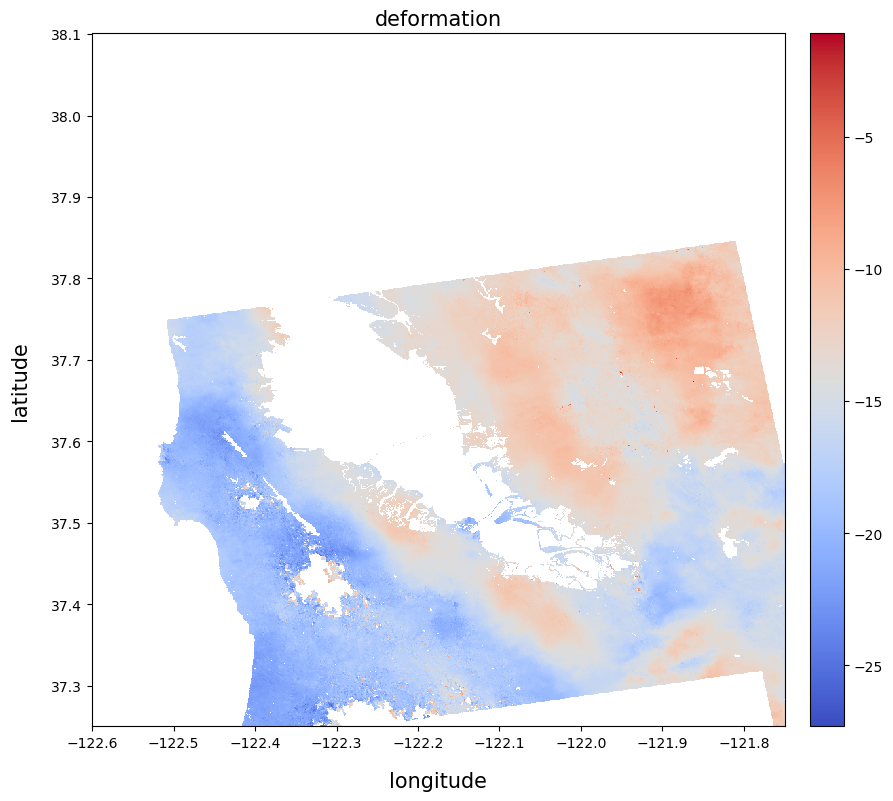

In [11]:
## view the plot
plot_layer('unwrappedPhase/20190121_20190109', 'deformation')

### View downloaded DEM

To download a Copernicus GLO-90, we specified the **`-d Download`** option. By default, outputs are written to the local directory, which can be changed to another location by specifying the path with the **`-w`** option. A DEM is needed for the extraction of full resolution meta-data layers.

The DEM is cropped to the common interferometric grid, stored under local subdirectory *DEM*, and given the filename *glo_90.dem* (i.e. nested as *DEM/glo_90.dem*). Note that for consistency, if a user specifies a path to a custom DEM, the cropped version is still stored under the local subdirectory *DEM* and shares the same filename as the input. You can use gdalinfo to retrieve information on the geospatial extent of the DEM.

In [12]:
!ls DEM/glo_90*
!gdalinfo DEM/glo_90.dem.vrt

DEM/glo_90.dem                  DEM/glo_90_expanded.dem
DEM/glo_90.dem.aux.xml          DEM/glo_90_expanded.dem.aux.xml
DEM/glo_90.dem.vrt              DEM/glo_90_expanded.hdr
DEM/glo_90.hdr                  DEM/glo_90_uncropped.vrt
Driver: VRT/Virtual Raster
Files: DEM/glo_90.dem.vrt
       DEM/glo_90.dem
Size is 1021, 1021
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-122.600784293000004,38.100818093000001)
Pixel Size = (0.000833333000000,-0.000833333000000)
Metadat

Execute the next cell to visualize the DEM.

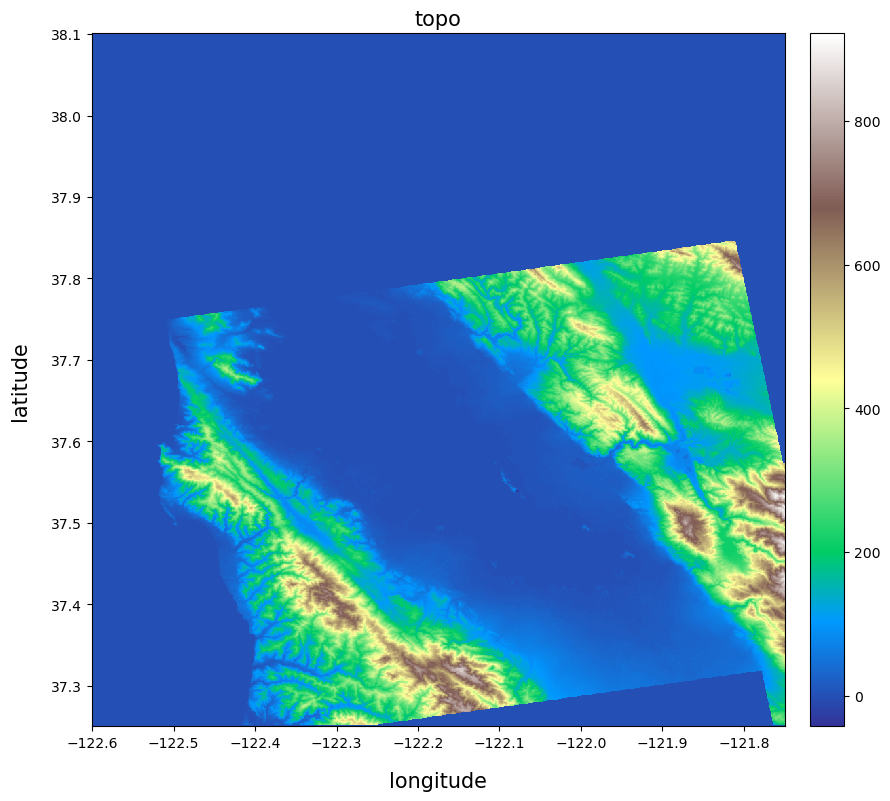

In [13]:
plot_layer('DEM/glo_90.dem',lay_type='topo')

### Examine *stack* files

Three VRT files *cohStack.vrt*, *connCompStack.vrt*, *unwrapStack.vrt* have been generated under the *stack* subdirectory of your specified work directory. They point to your extracted coherence, connected component, and unwrapped phase files, respectively. Let's take a look:

In [14]:
!ls stack

cohStack.vrt      ionoStack.vrt     troposphereTotal
connCompStack.vrt setStack.vrt      unwrapStack.vrt


Use the  **gdalinfo** to retrieve an overview of *unwrapStack.vrt*. You will see that it contains paths pointing each of the extracted interferograms in your stack, and basic projection information:

In [15]:
!gdalinfo stack/unwrapStack.vrt

Driver: VRT/Virtual Raster
Files: stack/unwrapStack.vrt
       stack/../unwrappedPhase/20190121_20190109.vrt
       stack/../unwrappedPhase/20190214_20190109.vrt
       stack/../unwrappedPhase/20190214_20190121.vrt
       stack/../unwrappedPhase/20190226_20190109.vrt
       stack/../unwrappedPhase/20190226_20190121.vrt
       stack/../unwrappedPhase/20190226_20190214.vrt
       stack/../unwrappedPhase/20190310_20190121.vrt
       stack/../unwrappedPhase/20190310_20190214.vrt
       stack/../unwrappedPhase/20190310_20190226.vrt
       stack/../unwrappedPhase/20190322_20190214.vrt
       stack/../unwrappedPhase/20190322_20190226.vrt
       stack/../unwrappedPhase/20190322_20190310.vrt
       stack/../unwrappedPhase/20190403_20190226.vrt
       stack/../unwrappedPhase/20190403_20190310.vrt
       stack/../unwrappedPhase/20190403_20190322.vrt
       stack/../unwrappedPhase/20190415_20190310.vrt
       stack/../unwrappedPhase/20190415_20190322.vrt
       stack/../unwrappedPhase/20190415_201

Use the **`-mdd unwrappedPhase`** option in **gdalinfo** to access the radar metadata (e.g. orbitDirection, UTCTime, Wavelength) corresponding to each of the interferogram data-layers, which are stored under the key-name *unwrappedPhase*:

In [16]:
!gdalinfo stack/unwrapStack.vrt -mdd unwrappedPhase

Driver: VRT/Virtual Raster
Files: stack/unwrapStack.vrt
       stack/../unwrappedPhase/20190121_20190109.vrt
       stack/../unwrappedPhase/20190214_20190109.vrt
       stack/../unwrappedPhase/20190214_20190121.vrt
       stack/../unwrappedPhase/20190226_20190109.vrt
       stack/../unwrappedPhase/20190226_20190121.vrt
       stack/../unwrappedPhase/20190226_20190214.vrt
       stack/../unwrappedPhase/20190310_20190121.vrt
       stack/../unwrappedPhase/20190310_20190214.vrt
       stack/../unwrappedPhase/20190310_20190226.vrt
       stack/../unwrappedPhase/20190322_20190214.vrt
       stack/../unwrappedPhase/20190322_20190226.vrt
       stack/../unwrappedPhase/20190322_20190310.vrt
       stack/../unwrappedPhase/20190403_20190226.vrt
       stack/../unwrappedPhase/20190403_20190310.vrt
       stack/../unwrappedPhase/20190403_20190322.vrt
       stack/../unwrappedPhase/20190415_20190310.vrt
       stack/../unwrappedPhase/20190415_20190322.vrt
       stack/../unwrappedPhase/20190415_201

We can now use our earlier defined plotting function to visualize one of the interferograms in your stack.

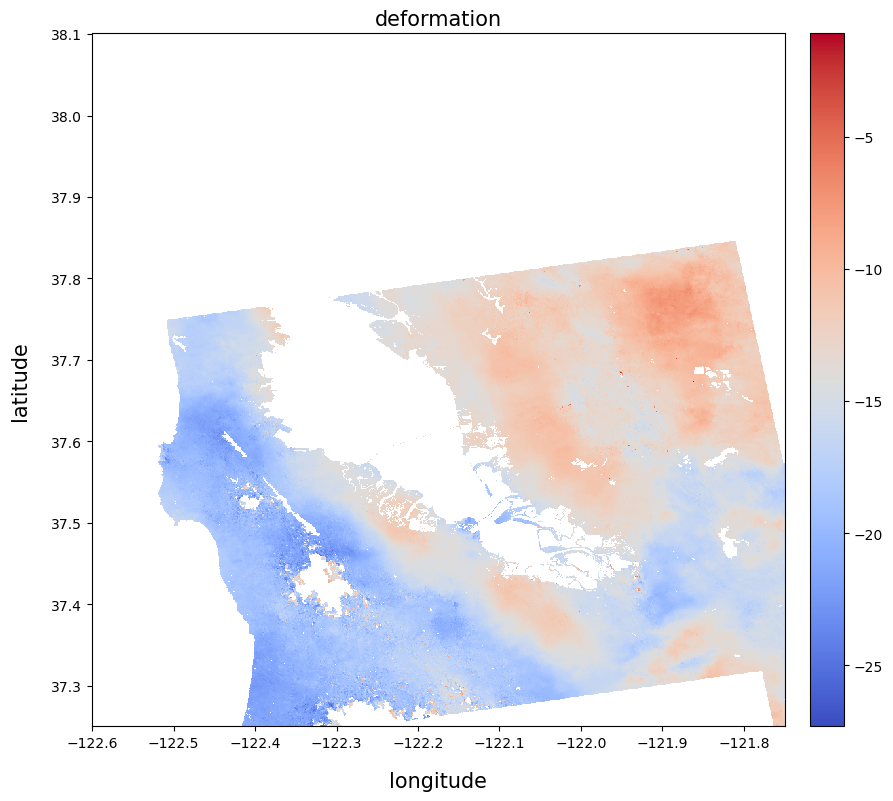

In [17]:
plot_layer('stack/unwrapStack.vrt', 'deformation', n_bands=1)